In [1]:
import pandas as pd
import yfinance as yf
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import json
import torch
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras import regularizers
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

import itertools
import torch
import statsmodels.api as sm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error,mean_squared_log_error
from torch import nn
%matplotlib inline
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.preprocessing import MinMaxScaler

from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras import regularizers

# Load the file
file_path = "stock_datasets/Samsung.xlsx"
stock_name = "005930.KS"
if file_path.endswith('.csv'):
    news_df = pd.read_csv(file_path)
elif file_path.endswith('.xlsx'):
    news_df = pd.read_excel(file_path)
else:
    raise ValueError("Unsupported file format. Please provide a CSV or XLSX file.")

# Remove rows where the 'Time' column has invalid dates
news_df['Time'] = pd.to_datetime(news_df['Time'], errors='coerce')  # Convert invalid dates to NaT
news_df = news_df.dropna(subset=['Time'])  # Drop rows with NaT in 'Time'

# Display the cleaned DataFrame
print(news_df)

                                         absolute href  \
0    https://www.investing.com/news/stock-market-ne...   
1    https://www.investing.com/news/pro/samsung-ele...   
2    https://www.investing.com/news/pro/samsung-ele...   
3    https://www.investing.com/news/stock-market-ne...   
4    https://www.investing.com/news/stock-market-ne...   
..                                                 ...   
995  https://www.investing.com/news/technology-news...   
996  https://www.investing.com/news/technology-news...   
997  https://www.investing.com/news/stock-market-ne...   
998  https://www.investing.com/news/technology-news...   
999  https://www.investing.com/news/stock-market-ne...   

                                                     z  \
0    https://i-invdn-com.investing.com/news/externa...   
1    https://i-invdn-com.investing.com/news/WallStr...   
2    https://i-invdn-com.investing.com/news/NewYork...   
3    https://i-invdn-com.investing.com/news/externa...   
4    https://

In [10]:
# Sort the DataFrame by 'Time'
news_df_sorted = news_df.sort_values(by='Time')

# Remove duplicate rows and select only 'Title' and 'Time' columns
news_df_cleaned = news_df_sorted[['Title', 'Time']].drop_duplicates()

# Rename the 'Time' column to 'Date'
news_df_cleaned = news_df_cleaned.rename(columns={'Time': 'Date'})

# Optionally, reset the index after removing duplicates
news_df_cleaned = news_df_cleaned.reset_index(drop=True)

# Save the cleaned data as JSON
news_df_cleaned.to_json(f"{stock_name}_news_title.json", orient='records', lines=True)

# Display the cleaned DataFrame
news_df_cleaned.head()


,Title,Date
0,Prosecutors raid LG headquarters over washing ...,2014-12-25
1,"For Qualcomm, China settlement may be just the...",2014-12-28
2,Public scorn greets LG and Samsung's storm in ...,2014-12-31
3,Wireless charging inches ahead as two industry...,2015-01-05
4,China's Xiaomi tests selling phones in stores ...,2015-01-07


In [11]:
# Determine the start and end dates from the news data
start_date = news_df_cleaned['Date'].min().strftime('%Y-%m-%d')
end_date = news_df_cleaned['Date'].max().strftime('%Y-%m-%d')

# Download historical data for AstraZeneca (AZN) based on the date range from the news data
stock_data = yf.download(stock_name, start=start_date, end=end_date)

# Display the first few rows of the data
print(stock_data.head())

[*********************100%%**********************]  1 of 1 completed

               Open     High      Low    Close     Adj Close    Volume
Date                                                                  
2014-12-26  26860.0  27100.0  26860.0  27040.0  21085.015625  11488100
2014-12-29  26900.0  26940.0  26580.0  26580.0  21029.630859   9637450
2014-12-30  26600.0  26700.0  26420.0  26540.0  20997.982422  10649100
2015-01-02  26800.0  26800.0  26540.0  26600.0  21045.451172   8774950
2015-01-05  26720.0  26720.0  26260.0  26660.0  21092.921875  10139500


In [12]:
from textblob import TextBlob

# Function to calculate sentiment polarity
def get_sentiment(text):
    if isinstance(text, str):  # Check if the input is a string
        analysis = TextBlob(text)
        return analysis.sentiment.polarity  # Returns sentiment polarity (-1 to 1)
    return None  # Return None for non-string inputs

# Clean the 'Title' column
news_df_cleaned['Title'] = news_df_cleaned['Title'].fillna("")  # Replace NaN with an empty string

# Apply the sentiment function to the 'Title' column
news_df_cleaned['Sentiment'] = news_df_cleaned['Title'].apply(get_sentiment)

# Display the resulting DataFrame
print(news_df_cleaned)

                                                 Title       Date  Sentiment
0    Prosecutors raid LG headquarters over washing ... 2014-12-25      0.000
1    For Qualcomm, China settlement may be just the... 2014-12-28      0.000
2    Public scorn greets LG and Samsung's storm in ... 2014-12-31      0.000
3    Wireless charging inches ahead as two industry... 2015-01-05      0.000
4    China's Xiaomi tests selling phones in stores ... 2015-01-07      0.000
..                                                 ...        ...        ...
975  Walmart, Amazon holiday spending rise as Targe... 2024-12-06      0.475
976  India antitrust body seeks Supreme Court heari... 2024-12-09      0.000
977  Samsung Electronics Co Ltd receives Investment... 2024-12-09      0.000
978  Samsung Electronics Co Ltd receives Investment... 2024-12-11      0.000
979  Samsung accuses India antitrust body of detain... 2024-12-12      0.000

[980 rows x 3 columns]


In [13]:
news_df_cleaned

,Title,Date,Sentiment
0,Prosecutors raid LG headquarters over washing ...,2014-12-25,0.000
1,"For Qualcomm, China settlement may be just the...",2014-12-28,0.000
2,Public scorn greets LG and Samsung's storm in ...,2014-12-31,0.000
3,Wireless charging inches ahead as two industry...,2015-01-05,0.000
4,China's Xiaomi tests selling phones in stores ...,2015-01-07,0.000
...,...,...,...
975,"Walmart, Amazon holiday spending rise as Targe...",2024-12-06,0.475
976,India antitrust body seeks Supreme Court heari...,2024-12-09,0.000
977,Samsung Electronics Co Ltd receives Investment...,2024-12-09,0.000
978,Samsung Electronics Co Ltd receives Investment...,2024-12-11,0.000


In [14]:
modelName = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(modelName)
model = AutoModelForSequenceClassification.from_pretrained(modelName)
def calculateDailySentiment(headlines):
    texts = [headline['heading'] for headline in headlines]
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512, return_attention_mask=True)
    outputs = model(**inputs)
    logits = outputs.logits
    scores = logits.softmax(dim=1)
    averageScore = scores.mean(dim=0).tolist()
    return averageScore
#enddef


def analyzeAndSaveSentiment(inputFile, outputFile):
    result = {}
    
    # Open the file and process each line as a separate JSON object
    with open(inputFile, 'r',  encoding="utf8") as file:
        for line in file:
            # Parse each line (record) as a separate JSON object
            record = json.loads(line)
            date = record.get('Date')
            title = record.get('Title')

            if date and title:
                # Convert the timestamp to a readable date
                readable_date = datetime.fromtimestamp(int(date) / 1000).strftime('%Y-%m-%d')
                
                # Prepare the headlines in the required format
                headlines = [{'heading': title}]
                averageScore = calculateDailySentiment(headlines)
                print(f"{readable_date} > {averageScore}")
                result[readable_date] = averageScore
            #endif
        #endfor
    #endwith

    # Write the result to an output file
    with open(outputFile, 'w', encoding="utf8") as outFile:
        json.dump(result, outFile, indent=2)
    #endwith
#enddef

In [15]:
inputJsonFile = f"{stock_name}_news_title.json"
outputJsonFile = f"{stock_name}_news_sentimentscore.json"

analyzeAndSaveSentiment(inputJsonFile, outputJsonFile)

2014-12-25 > [0.660025954246521, 0.18060706555843353, 0.09813599288463593, 0.035777654498815536, 0.02545325644314289]
2014-12-28 > [0.14767129719257355, 0.22276926040649414, 0.3496577739715576, 0.18653246760368347, 0.09336917847394943]
2014-12-31 > [0.4954206943511963, 0.12774702906608582, 0.08120722323656082, 0.09734772890806198, 0.19827741384506226]
2015-01-05 > [0.2596927583217621, 0.2332209050655365, 0.1592402309179306, 0.16283637285232544, 0.18500971794128418]
2015-01-07 > [0.22378985583782196, 0.1814647614955902, 0.172938734292984, 0.19666437804698944, 0.225142240524292]
2015-01-08 > [0.07354817539453506, 0.053617753088474274, 0.11306151002645493, 0.2894044518470764, 0.4703681170940399]
2015-01-12 > [0.3401440978050232, 0.4330204427242279, 0.20174378156661987, 0.019855331629514694, 0.005236305296421051]
2015-01-15 > [0.24307778477668762, 0.11748617142438889, 0.1533273160457611, 0.20833683013916016, 0.277771919965744]
2015-01-20 > [0.45344460010528564, 0.23907625675201416, 0.14960

2015-04-22 > [0.1820417046546936, 0.11429794877767563, 0.11750748753547668, 0.21941272914409637, 0.36674007773399353]
2015-04-22 > [0.14048580825328827, 0.22928990423679352, 0.28756147623062134, 0.21634654700756073, 0.12631620466709137]
2015-04-23 > [0.18270578980445862, 0.14005747437477112, 0.17110806703567505, 0.23831681907176971, 0.2678118348121643]
2015-04-23 > [0.16277018189430237, 0.19924408197402954, 0.3527396321296692, 0.2042228728532791, 0.0810231864452362]
2015-04-24 > [0.053436748683452606, 0.041883427649736404, 0.1280173510313034, 0.2957310676574707, 0.48093143105506897]
2015-04-24 > [0.10419315099716187, 0.08985324949026108, 0.14984601736068726, 0.2803393304347992, 0.3757682740688324]
2015-04-27 > [0.12265212088823318, 0.0910026952624321, 0.1284489780664444, 0.27356410026550293, 0.3843320906162262]
2015-04-28 > [0.09325237572193146, 0.1267600804567337, 0.1938881129026413, 0.2581859827041626, 0.32791346311569214]
2015-04-28 > [0.051668234169483185, 0.06289631128311157, 0.11

2015-07-10 > [0.29566219449043274, 0.1499572992324829, 0.18523746728897095, 0.17104224860668182, 0.19810083508491516]
2015-07-10 > [0.2557491660118103, 0.23647144436836243, 0.1874784529209137, 0.1689927726984024, 0.15130819380283356]
2015-07-13 > [0.012737802229821682, 0.010299335233867168, 0.03491193428635597, 0.21857361495494843, 0.723477303981781]
2015-07-14 > [0.3871115744113922, 0.3991943597793579, 0.1850418895483017, 0.022941885516047478, 0.005710230208933353]
2015-07-15 > [0.10125157982110977, 0.1141839474439621, 0.2249925136566162, 0.24218328297138214, 0.3173886835575104]
2015-07-16 > [0.4558827877044678, 0.24747994542121887, 0.1444604992866516, 0.08759942650794983, 0.06457734853029251]
2015-07-16 > [0.08165767788887024, 0.10793229192495346, 0.19187189638614655, 0.3059857487678528, 0.31255242228507996]
2015-07-17 > [0.153330996632576, 0.06372520327568054, 0.06239444389939308, 0.16161176562309265, 0.5589376091957092]
2015-07-20 > [0.3677995502948761, 0.1856909990310669, 0.153311

2015-10-16 > [0.06527644395828247, 0.05661595240235329, 0.10308722406625748, 0.2632695138454437, 0.5117508769035339]
2015-10-20 > [0.054298367351293564, 0.05509932339191437, 0.1297069936990738, 0.3377167582511902, 0.4231785237789154]
2015-10-21 > [0.39938339591026306, 0.2024209350347519, 0.14439842104911804, 0.11940816044807434, 0.13438916206359863]
2015-10-21 > [0.32219696044921875, 0.1540251523256302, 0.17870531976222992, 0.1645507663488388, 0.1805218905210495]
2015-10-21 > [0.09303833544254303, 0.07912001758813858, 0.11570414155721664, 0.273290753364563, 0.43884673714637756]
2015-10-22 > [0.15487204492092133, 0.14179734885692596, 0.24114303290843964, 0.2517620623111725, 0.210425466299057]
2015-10-26 > [0.19556748867034912, 0.12319085001945496, 0.17433838546276093, 0.22288936376571655, 0.28401389718055725]
2015-10-27 > [0.14388681948184967, 0.11083467304706573, 0.11320202052593231, 0.21979336440563202, 0.41228315234184265]
2015-10-27 > [0.015329607762396336, 0.021610049530863762, 0.0

2016-01-20 > [0.3882087171077728, 0.1722751259803772, 0.15638625621795654, 0.12938889861106873, 0.15374094247817993]
2016-01-20 > [0.2891818881034851, 0.27482253313064575, 0.23762147128582, 0.1297501176595688, 0.06862391531467438]
2016-01-21 > [0.08359254896640778, 0.07025545090436935, 0.1435241997241974, 0.2785905599594116, 0.42403727769851685]
2016-01-21 > [0.19923172891139984, 0.23548081517219543, 0.3043232262134552, 0.18540804088115692, 0.07555614411830902]
2016-01-21 > [0.09058450907468796, 0.0855664610862732, 0.15836957097053528, 0.28021538257598877, 0.3852640688419342]
2016-01-22 > [0.34254440665245056, 0.42100077867507935, 0.19591623544692993, 0.03009006381034851, 0.010448437184095383]
2016-01-23 > [0.5208884477615356, 0.21172651648521423, 0.16035842895507812, 0.06536751240491867, 0.04165908321738243]
2016-01-24 > [0.10392950475215912, 0.12142301350831985, 0.2268902212381363, 0.288131445646286, 0.25962576270103455]
2016-01-26 > [0.016984380781650543, 0.022007938474416733, 0.076

2016-04-07 > [0.05093509331345558, 0.12472812086343765, 0.41950100660324097, 0.31178829073905945, 0.09304746985435486]
2016-04-07 > [0.3099205493927002, 0.22720834612846375, 0.17637477815151215, 0.1468253880739212, 0.13967092335224152]
2016-04-12 > [0.005385728552937508, 0.005234513897448778, 0.016740841791033745, 0.13246984779834747, 0.8401690125465393]
2016-04-12 > [0.2298882156610489, 0.20505183935165405, 0.15327072143554688, 0.19290603697299957, 0.218883216381073]
2016-04-14 > [0.16677239537239075, 0.20002615451812744, 0.25465911626815796, 0.24035419523715973, 0.1381882131099701]
2016-04-16 > [0.5439903736114502, 0.24705325067043304, 0.12190175801515579, 0.04780163988471031, 0.03925289586186409]
2016-04-18 > [0.23223255574703217, 0.1530304104089737, 0.20653003454208374, 0.23114274442195892, 0.17706431448459625]
2016-04-19 > [0.3010590970516205, 0.17629162967205048, 0.10206808149814606, 0.15347346663475037, 0.2671077847480774]
2016-04-20 > [0.36001017689704895, 0.33901020884513855, 

2016-07-26 > [0.10553614050149918, 0.16713787615299225, 0.25633344054222107, 0.2901141345500946, 0.1808784157037735]
2016-07-27 > [0.4979371130466461, 0.2985311448574066, 0.13128946721553802, 0.03854081779718399, 0.03370155766606331]
2016-07-28 > [0.4276668429374695, 0.1943499743938446, 0.1349523961544037, 0.11432866752147675, 0.1287020891904831]
2016-07-28 > [0.08529963344335556, 0.0879369005560875, 0.17729194462299347, 0.31145521998405457, 0.3380163013935089]
2016-07-28 > [0.013970531523227692, 0.03128747642040253, 0.11511382460594177, 0.41336482763290405, 0.42626330256462097]
2016-07-28 > [0.028760254383087158, 0.04277336597442627, 0.10605903714895248, 0.37896955013275146, 0.4434378743171692]
2016-07-28 > [0.038559895008802414, 0.05849355086684227, 0.15942226350307465, 0.3875637948513031, 0.35596054792404175]
2016-07-29 > [0.5196287631988525, 0.18358471989631653, 0.14448590576648712, 0.08412583917379379, 0.06817477196455002]
2016-08-01 > [0.07369716465473175, 0.09700972586870193, 0.

2016-09-22 > [0.12245416641235352, 0.10616450011730194, 0.20544853806495667, 0.28039249777793884, 0.28554028272628784]
2016-09-22 > [0.11837606877088547, 0.13387531042099, 0.21630635857582092, 0.2760034501552582, 0.2554387152194977]
2016-09-23 > [0.45605140924453735, 0.20061001181602478, 0.15901315212249756, 0.10200559347867966, 0.08231982588768005]
2016-09-23 > [0.3890738785266876, 0.17252065241336823, 0.12314476072788239, 0.13973429799079895, 0.17552641034126282]
2016-09-26 > [0.11650432646274567, 0.06337685883045197, 0.080860935151577, 0.24385841190814972, 0.49539947509765625]
2016-09-27 > [0.43844956159591675, 0.26378464698791504, 0.11470822989940643, 0.0809178277850151, 0.10213973373174667]
2016-09-28 > [0.5042137503623962, 0.2402278631925583, 0.14557619392871857, 0.06252536177635193, 0.0474567674100399]
2016-09-29 > [0.04632452875375748, 0.033495739102363586, 0.05812859535217285, 0.21783088147640228, 0.6442203521728516]
2016-09-29 > [0.25680050253868103, 0.18655304610729218, 0.20

2016-10-26 > [0.42636245489120483, 0.24862201511859894, 0.1635264754295349, 0.09525694698095322, 0.06623201817274094]
2016-10-26 > [0.4188272953033447, 0.3780152499675751, 0.17218023538589478, 0.022787971422076225, 0.008189171552658081]
2016-10-26 > [0.260140597820282, 0.3121526837348938, 0.2617410123348236, 0.11163270473480225, 0.05433304235339165]
2016-10-26 > [0.25254297256469727, 0.3247584402561188, 0.25689858198165894, 0.10338200628757477, 0.06241800636053085]
2016-10-26 > [0.020871615037322044, 0.02754076011478901, 0.07404235750436783, 0.29592177271842957, 0.5816234350204468]
2016-10-26 > [0.27811938524246216, 0.37771865725517273, 0.2616669535636902, 0.05580225586891174, 0.026692820712924004]
2016-10-27 > [0.4216320812702179, 0.28093788027763367, 0.1764165610074997, 0.0702984631061554, 0.05071500316262245]
2016-10-27 > [0.6776715517044067, 0.2013883888721466, 0.08437108993530273, 0.022175781428813934, 0.01439316663891077]
2016-10-30 > [0.011183686554431915, 0.017170125618577003, 

2023-03-09 > [0.4012506306171417, 0.18034647405147552, 0.13623256981372833, 0.140910342335701, 0.14125998318195343]
2023-03-17 > [0.05359106883406639, 0.04819660261273384, 0.09340819716453552, 0.31284430623054504, 0.4919597804546356]
2023-03-29 > [0.2864300310611725, 0.15266139805316925, 0.22206047177314758, 0.1874249428510666, 0.1514231264591217]
2023-04-08 > [0.2864300310611725, 0.15266139805316925, 0.22206047177314758, 0.1874249428510666, 0.1514231264591217]
2023-04-10 > [0.2864300310611725, 0.15266139805316925, 0.22206047177314758, 0.1874249428510666, 0.1514231264591217]
2023-04-11 > [0.2864300310611725, 0.15266139805316925, 0.22206047177314758, 0.1874249428510666, 0.1514231264591217]
2023-04-13 > [0.006305769085884094, 0.00927760824561119, 0.060668859630823135, 0.3968197703361511, 0.5269280672073364]
2023-04-13 > [0.5901845693588257, 0.15373188257217407, 0.10345374792814255, 0.08326484262943268, 0.06936494261026382]
2023-04-17 > [0.4067145586013794, 0.2905806303024292, 0.215239554

2023-09-07 > [0.2864300310611725, 0.15266139805316925, 0.22206047177314758, 0.1874249428510666, 0.1514231264591217]
2023-09-07 > [0.06465988606214523, 0.06818877905607224, 0.10394012182950974, 0.2675422430038452, 0.4956689476966858]
2023-09-08 > [0.020569849759340286, 0.01877734623849392, 0.04758896306157112, 0.2462131381034851, 0.6668506860733032]
2023-09-08 > [0.04824910685420036, 0.05595359951257706, 0.11584461480379105, 0.3238554000854492, 0.4560973048210144]
2023-09-09 > [0.021422339603304863, 0.018155789002776146, 0.049493398517370224, 0.23514917492866516, 0.6757792830467224]
2023-09-12 > [0.32233402132987976, 0.16613337397575378, 0.15569977462291718, 0.15811672806739807, 0.19771605730056763]
2023-09-12 > [0.2864300310611725, 0.15266139805316925, 0.22206047177314758, 0.1874249428510666, 0.1514231264591217]
2023-09-13 > [0.2456429898738861, 0.17468133568763733, 0.20331133902072906, 0.20281082391738892, 0.173553466796875]
2023-09-13 > [0.11550658196210861, 0.1845209300518036, 0.301

2024-01-17 > [0.020619818940758705, 0.0292472206056118, 0.08797825872898102, 0.3335494101047516, 0.5286052227020264]
2024-01-17 > [0.1630982607603073, 0.10206674039363861, 0.18250419199466705, 0.24885337054729462, 0.30347740650177]
2024-01-17 > [0.031599342823028564, 0.0306913573294878, 0.06957554817199707, 0.2538682520389557, 0.614265501499176]
2024-01-17 > [0.044442009180784225, 0.04311547055840492, 0.0869155004620552, 0.2405451238155365, 0.5849818587303162]
2024-01-17 > [0.03230521082878113, 0.020369568839669228, 0.03611324355006218, 0.1436617225408554, 0.7675502300262451]
2024-01-17 > [0.016779223456978798, 0.016999151557683945, 0.04610380902886391, 0.2566416263580322, 0.6634761691093445]
2024-01-18 > [0.08809159696102142, 0.09923327714204788, 0.23249594867229462, 0.30379951000213623, 0.27637970447540283]
2024-01-24 > [0.16265647113323212, 0.08575946092605591, 0.12144102156162262, 0.22794209420681, 0.40220096707344055]
2024-01-26 > [0.27634769678115845, 0.3201386630535126, 0.235733

2024-05-21 > [0.06267860531806946, 0.07887934893369675, 0.16874630749225616, 0.36035192012786865, 0.3293437659740448]
2024-05-22 > [0.235953226685524, 0.13009284436702728, 0.15131326019763947, 0.20032690465450287, 0.282313734292984]
2024-05-23 > [0.3997964859008789, 0.3039366900920868, 0.18197205662727356, 0.07676459848880768, 0.037530235946178436]
2024-05-23 > [0.5908948183059692, 0.17117221653461456, 0.0937744751572609, 0.05974690988659859, 0.0844116136431694]
2024-05-23 > [0.35522791743278503, 0.3817184567451477, 0.19114547967910767, 0.04856553301215172, 0.023342648521065712]
2024-05-24 > [0.027717014774680138, 0.03117542900145054, 0.08895416557788849, 0.3367582857608795, 0.5153951048851013]
2024-05-26 > [0.22470009326934814, 0.17028722167015076, 0.1763848215341568, 0.18708190321922302, 0.24154596030712128]
2024-05-27 > [0.2864300310611725, 0.15266139805316925, 0.22206047177314758, 0.1874249428510666, 0.1514231264591217]
2024-05-27 > [0.39258071780204773, 0.2001515030860901, 0.19450

2024-08-27 > [0.0707203596830368, 0.052337199449539185, 0.08701574057340622, 0.2431330531835556, 0.5467936396598816]
2024-08-29 > [0.2864300310611725, 0.15266139805316925, 0.22206047177314758, 0.1874249428510666, 0.1514231264591217]
2024-08-29 > [0.12451285868883133, 0.11985907703638077, 0.23358049988746643, 0.27973616123199463, 0.24231143295764923]
2024-08-30 > [0.37888267636299133, 0.16738809645175934, 0.1975731998682022, 0.14192280173301697, 0.11423313617706299]
2024-09-06 > [0.5636148452758789, 0.22085948288440704, 0.13897469639778137, 0.0510643795132637, 0.025486599653959274]
2024-09-09 > [0.2864300310611725, 0.15266139805316925, 0.22206047177314758, 0.1874249428510666, 0.1514231264591217]
2024-09-10 > [0.5586074590682983, 0.18931803107261658, 0.1095890998840332, 0.07191332429647446, 0.07057208567857742]
2024-09-10 > [0.12708711624145508, 0.17323774099349976, 0.2485813945531845, 0.24222147464752197, 0.20887233316898346]
2024-09-11 > [0.2864300310611725, 0.15266139805316925, 0.2220

In [16]:
# Load the sentiment scores from the JSON file
with open(f"{stock_name}_news_sentimentscore.json", 'r') as f:
    sentiment_data = json.load(f)

# Create a DataFrame to store the sentiment scores without averaging them
processed_data = {
    'Date': [],
    'SentimentScores': []
}

# Iterate through the JSON data and append the sentiment scores for each date
for date, scores in sentiment_data.items():
    processed_data['Date'].append(date)
    processed_data['SentimentScores'].append(scores)  # Keep the list of sentiment scores

# Convert processed data to a DataFrame
news_sentiment_df = pd.DataFrame(processed_data)

# Ensure the 'Date' column is in datetime format
news_sentiment_df['Date'] = pd.to_datetime(news_sentiment_df['Date'])

# Display the DataFrame
news_sentiment_df


,Date,SentimentScores
0,2014-12-25,"[0.660025954246521, 0.18060706555843353, 0.098..."
1,2014-12-28,"[0.14767129719257355, 0.22276926040649414, 0.3..."
2,2014-12-31,"[0.4954206943511963, 0.12774702906608582, 0.08..."
3,2015-01-05,"[0.2596927583217621, 0.2332209050655365, 0.159..."
4,2015-01-07,"[0.22378985583782196, 0.1814647614955902, 0.17..."
...,...,...
598,2024-12-04,"[0.4118427336215973, 0.2799176275730133, 0.168..."
599,2024-12-06,"[0.07437363266944885, 0.050765614956617355, 0...."
600,2024-12-09,"[0.2864300310611725, 0.15266139805316925, 0.22..."
601,2024-12-11,"[0.2864300310611725, 0.15266139805316925, 0.22..."


In [17]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-26,26860.0,27100.0,26860.0,27040.0,21085.015625,11488100
2014-12-29,26900.0,26940.0,26580.0,26580.0,21029.630859,9637450
2014-12-30,26600.0,26700.0,26420.0,26540.0,20997.982422,10649100
2015-01-02,26800.0,26800.0,26540.0,26600.0,21045.451172,8774950
2015-01-05,26720.0,26720.0,26260.0,26660.0,21092.921875,10139500
...,...,...,...,...,...,...
2024-12-05,53200.0,54400.0,53200.0,53700.0,53700.000000,23588277
2024-12-06,53900.0,54400.0,52700.0,54100.0,54100.000000,22861874
2024-12-09,53500.0,54600.0,53200.0,53400.0,53400.000000,26227680


In [18]:
news_sentiment_df.head()

,Date,SentimentScores
0,2014-12-25,"[0.660025954246521, 0.18060706555843353, 0.098..."
1,2014-12-28,"[0.14767129719257355, 0.22276926040649414, 0.3..."
2,2014-12-31,"[0.4954206943511963, 0.12774702906608582, 0.08..."
3,2015-01-05,"[0.2596927583217621, 0.2332209050655365, 0.159..."
4,2015-01-07,"[0.22378985583782196, 0.1814647614955902, 0.17..."


In [19]:
# Ensure the index of stock_data is converted to datetime if not already done
stock_data.index = pd.to_datetime(stock_data.index)

# Reset the index of stock_data to turn 'Date' into a regular column
stock_data = stock_data.reset_index()

# Merge the two DataFrames on the 'Date' column
dfMerged = pd.merge(stock_data, news_sentiment_df, on='Date', how='left')

# Check if each element in 'SentimentScores' is a list, and replace invalid ones with NaN or an empty list
dfMerged['SentimentScores'] = dfMerged['SentimentScores'].apply(lambda x: x if isinstance(x, list) else [None] * 5)

# Ensure each list in 'SentimentScores' has 5 elements (or adjust this if your data varies)
dfMerged['SentimentScores'] = dfMerged['SentimentScores'].apply(lambda x: x if len(x) == 5 else [None] * 5)

# Convert the 'SentimentScores' list into separate columns
dfSentimentColumns = pd.DataFrame(dfMerged['SentimentScores'].tolist(), columns=['feature1', 'feature2', 'feature3', 'feature4', 'feature5'])

# Concatenate the origi|nal DataFrame with the new sentiment columns
dfMerged = pd.concat([dfMerged, dfSentimentColumns], axis=1)

# Drop unnecessary columns
dfMerged = dfMerged.drop(columns=['SentimentScores'])

# Display the merged DataFrame
dfMerged.head()


,Date,Open,High,Low,Close,Adj Close,Volume,feature1,feature2,feature3,feature4,feature5
0,2014-12-26,26860.0,27100.0,26860.0,27040.0,21085.015625,11488100,NaN,NaN,NaN,NaN,NaN
1,2014-12-29,26900.0,26940.0,26580.0,26580.0,21029.630859,9637450,NaN,NaN,NaN,NaN,NaN
2,2014-12-30,26600.0,26700.0,26420.0,26540.0,20997.982422,10649100,NaN,NaN,NaN,NaN,NaN
3,2015-01-02,26800.0,26800.0,26540.0,26600.0,21045.451172,8774950,NaN,NaN,NaN,NaN,NaN
4,2015-01-05,26720.0,26720.0,26260.0,26660.0,21092.921875,10139500,0.259693,0.233221,0.15924,0.162836,0.18501


In [20]:
dfMerged[['feature1', 'feature2','feature3','feature4','feature5']] = dfMerged[['feature1', 'feature2','feature3','feature4','feature5']].interpolate(method='linear', axis=0)


In [21]:
dfMerged

,Date,Open,High,Low,Close,Adj Close,Volume,feature1,feature2,feature3,feature4,feature5
0,2014-12-26,26860.0,27100.0,26860.0,27040.0,21085.015625,11488100,NaN,NaN,NaN,NaN,NaN
1,2014-12-29,26900.0,26940.0,26580.0,26580.0,21029.630859,9637450,NaN,NaN,NaN,NaN,NaN
2,2014-12-30,26600.0,26700.0,26420.0,26540.0,20997.982422,10649100,NaN,NaN,NaN,NaN,NaN
3,2015-01-02,26800.0,26800.0,26540.0,26600.0,21045.451172,8774950,NaN,NaN,NaN,NaN,NaN
4,2015-01-05,26720.0,26720.0,26260.0,26660.0,21092.921875,10139500,0.259693,0.233221,0.159240,0.162836,0.185010
...,...,...,...,...,...,...,...,...,...,...,...,...
2441,2024-12-05,53200.0,54400.0,53200.0,53700.0,53700.000000,23588277,0.243108,0.165342,0.127007,0.135065,0.329478
2442,2024-12-06,53900.0,54400.0,52700.0,54100.0,54100.000000,22861874,0.074374,0.050766,0.085659,0.182607,0.606594
2443,2024-12-09,53500.0,54600.0,53200.0,53400.0,53400.000000,26227680,0.286430,0.152661,0.222060,0.187425,0.151423
2444,2024-12-10,54500.0,54500.0,53700.0,54000.0,54000.000000,20783970,0.286430,0.152661,0.222060,0.187425,0.151423


In [22]:
def createDataset(dataset, target, lookBack=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - lookBack):
        a = dataset[i:(i + lookBack), :]
        dataX.append(a)
        dataY.append(target[i + lookBack])
    return np.array(dataX), np.array(dataY)
#enddef

In [25]:
dfMerged = stock_data
features = dfMerged.drop(['Date', 'Close'], axis=1).values
target = dfMerged['Close'].values

scalerFeatures = MinMaxScaler(feature_range=(0, 1))
scalerTarget = MinMaxScaler(feature_range=(0, 1))

featuresScaled = scalerFeatures.fit_transform(features)
targetScaled = scalerTarget.fit_transform(target.reshape(-1, 1))

lookBack = 60
X, y = createDataset(featuresScaled, targetScaled, lookBack)
print(X[:2])
print(y[:2])

trainSize = int(len(X) * 0.7)
testSize = len(X) - trainSize
trainX, testX = X[0:trainSize, :], X[trainSize:len(X), :]
trainY, testY = y[0:trainSize], y[trainSize:len(y)]

trainX = np.reshape(trainX, (trainX.shape[0], lookBack, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], lookBack, testX.shape[2]))

[[[0.07977952 0.07461498 0.09006392 0.05947708 0.12721278]
  [0.08035973 0.07249071 0.08599651 0.05869051 0.10671972]
  [0.07600812 0.0693043  0.08367228 0.05824104 0.11792217]
  [0.0789092  0.07063197 0.08541546 0.05891519 0.09716888]
  [0.07774877 0.06956984 0.08134805 0.05958936 0.11227914]
  [0.07165651 0.06452469 0.07408483 0.05104982 0.16870939]
  [0.06556426 0.06293149 0.07234166 0.0537465  0.15860211]
  [0.07861909 0.07036644 0.08047647 0.05531958 0.16031683]
  [0.07136641 0.06585236 0.08163858 0.05531958 0.1031203 ]
  [0.0710763  0.06505576 0.07786171 0.05576902 0.09219081]
  [0.07136641 0.07063197 0.07757118 0.06093774 0.13613022]
  [0.07861909 0.07461498 0.08773969 0.06228614 0.15870731]
  [0.08035973 0.07302177 0.08599651 0.05981412 0.15617869]
  [0.07716855 0.06903877 0.08134805 0.05576902 0.15024997]
  [0.07571802 0.07302177 0.08338175 0.0618367  0.07389251]
  [0.08181027 0.07912905 0.09064497 0.06835372 0.14703369]
  [0.08674209 0.08523633 0.09500291 0.07352241 0.1839591

In [26]:
batchSize = 8
epoch = 88
neurons = 135
dropout = 0.15

model = Sequential()
model.add(LSTM(neurons, return_sequences=True, activation='tanh', input_shape=(lookBack, features.shape[1])))
model.add(Dropout(dropout))
model.add(LSTM(neurons, return_sequences=True, activation='tanh'))
model.add(Dropout(dropout))
model.add(LSTM(neurons, activation='tanh'))
model.add(Dropout(dropout))

model.add(Dense(units=1, activation='linear', activity_regularizer=regularizers.l1(0.00001)))
#model.add(Activation('tanh'))
model.summary()

model.compile(loss='mean_squared_error' , optimizer='RMSprop')

model.fit(trainX, trainY, epochs=epoch, batch_size=batchSize, verbose=1, validation_split=0.2)

C:\Users\will\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 135)        │        76,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 135)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 135)        │       146,340 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 135)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 135)            │       146,340 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 135)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 368,956 (1.41 MB)

 Trainable params: 368,956 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/88
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0137 - val_loss: 0.0022
Epoch 2/88
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 3/88
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0021 - val_loss: 0.0182
Epoch 4/88
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0014 - val_loss: 0.0044
Epoch 5/88
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0014 - val_loss: 0.0039
Epoch 6/88
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 7/88
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 9.2779e-04 - val_loss: 0.0148
Epoch 8/88
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0010 - val_loss: 0.0039
Epoch 9/88
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 8.7303e-04 - val_loss: 0.0015
Epoch 10/88
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 8.1428e-04 - val_loss: 0.0011
Epoch 11/88
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 8.4835e-04 - val_loss: 0.0028
Epoch 12/88
167/167 ━━━━━

167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 3.9097e-04 - val_loss: 7.3934e-04
Epoch 67/88
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 3.9944e-04 - val_loss: 8.7152e-04
Epoch 68/88
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 3.7270e-04 - val_loss: 0.0014
Epoch 69/88
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 4.1339e-04 - val_loss: 0.0011
Epoch 70/88
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 4.0163e-04 - val_loss: 6.7173e-04
Epoch 71/88
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 4.2907e-04 - val_loss: 7.3143e-04
Epoch 72/88
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 3.9721e-04 - val_loss: 0.0013
Epoch 73/88
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 4.1836e-04 - val_loss: 0.0014
Epoch 74/88
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 3.9577e-04 - val_loss: 0.0018
Epoch 75/88
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 3.7677e-04 - val_loss: 0.0023
Epoch 76/88
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 3.9457e-04 - v

In [27]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredictInv = scalerTarget.inverse_transform(trainPredict)
trainYInv = scalerTarget.inverse_transform(np.reshape(trainY, (trainY.shape[0], 1)))
testPredictInv = scalerTarget.inverse_transform(testPredict)
testYInv = scalerTarget.inverse_transform(np.reshape(testY, (testY.shape[0], 1)))

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


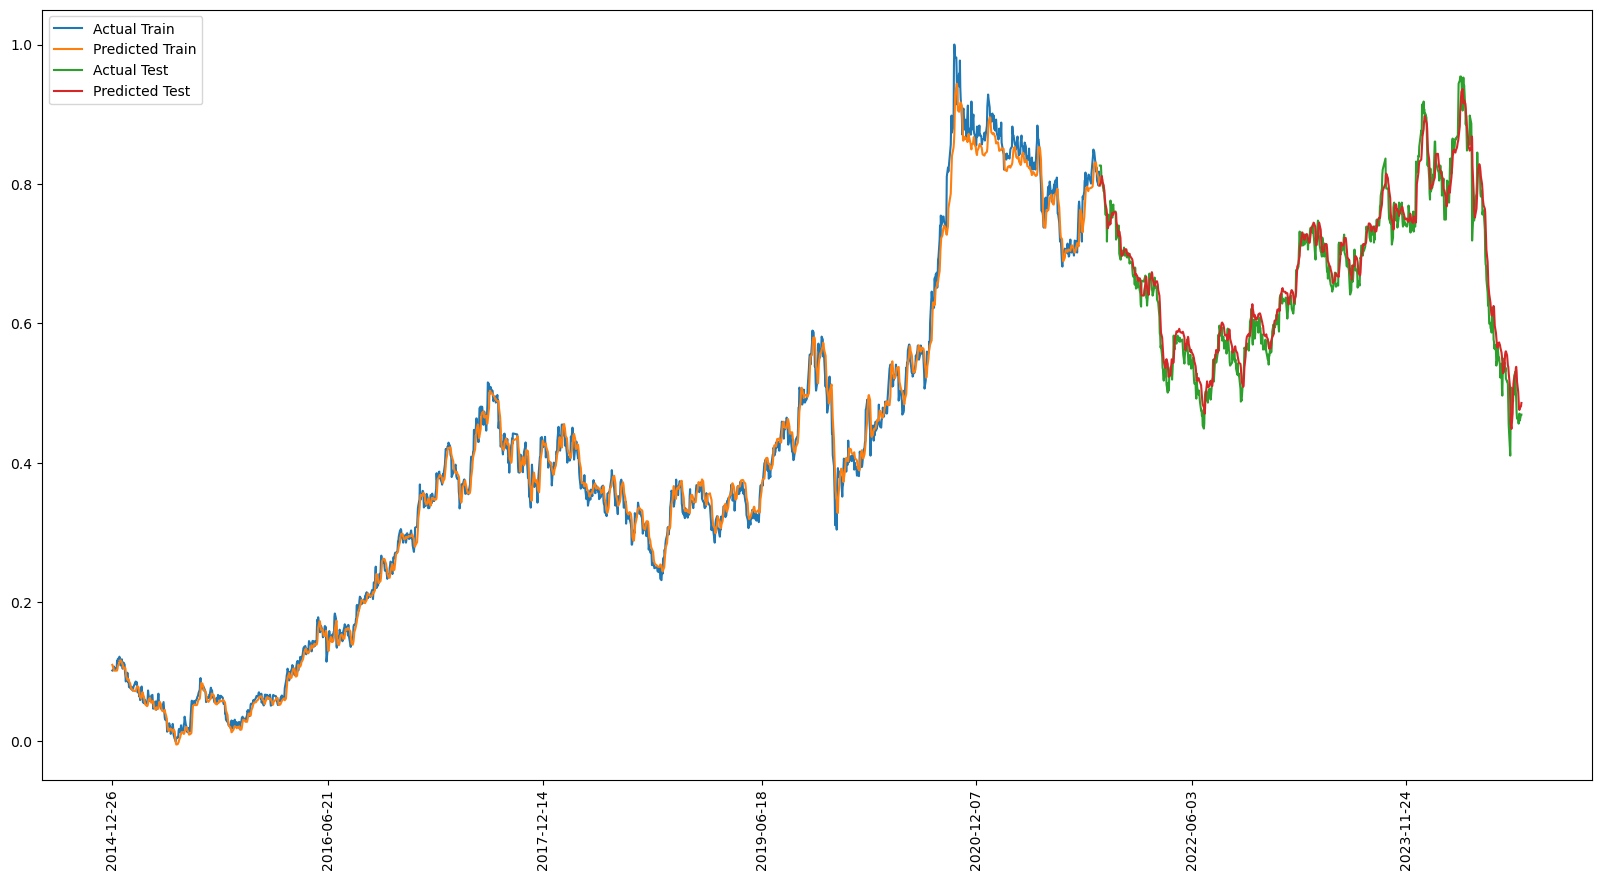

In [28]:
dates = dfMerged['Date'].values
sampleInterval = 365
sampledDates = dates[::sampleInterval]

plt.figure(figsize=(20, 10))
plt.plot(dates[:len(trainY)], trainY, label='Actual Train')
plt.plot(dates[:len(trainPredict)], trainPredict, label='Predicted Train')
plt.plot(dates[len(trainY):len(trainY) + len(testY)], testY, label='Actual Test')
plt.plot(dates[len(trainPredict):len(trainPredict) + len(testPredict)], testPredict, label='Predicted Test')

plt.xticks(sampledDates, rotation=90)

plt.legend()
plt.show()

In [29]:
lstm_predictions = model.predict(testX)

testY_univariate = testY[:, 0]

# Flatten the LSTM predictions if necessary
lstm_predictions = lstm_predictions.squeeze()  # Shape will now be (495,)

# Calculate residuals between true values and predictions
residuals = testY_univariate - lstm_predictions  # Shape will be (495,)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [30]:
import pmdarima as pm
import numpy as np

# Assuming residuals are univariate, ensure they are in 1D
residuals = residuals.reshape(-1)  # Flatten if necessary

# Fit auto_arima model
auto_arima_model = pm.auto_arima(residuals, 
                                 start_p=0, start_q=0,       # Initial p and q values
                                 max_p=10, max_q=10,           # Maximum p and q values to explore
                                 d=None,                     # Let auto_arima detect the order of differencing (d)
                                 seasonal=False,             # Set False for non-seasonal data
                                 stepwise=True,              # Use stepwise search to reduce computation
                                 trace=True,                 # Show output of model fitting process
                                 error_action='ignore',      # Ignore if an order does not fit
                                 suppress_warnings=True,     # Suppress warnings for cleaner output
                                 maxiter=10)                 # Set a limit for iterations

# Summary of the chosen ARIMA model
print(auto_arima_model.summary())

# Forecast residuals for the length of the test set
arima_residual_predictions = auto_arima_model.predict(n_periods=len(testY))

# Check the predicted residuals
print(arima_residual_predictions.shape)
print(arima_residual_predictions[:5])


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3350.751, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-3829.985, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-3744.656, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-3858.282, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-3863.919, Time=0.13 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-3864.443, Time=0.16 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-3866.521, Time=0.17 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=-3873.634, Time=0.09 sec
 ARIMA(7,0,0)(0,0,0)[0]             : AIC=-3871.751, Time=0.19 sec
 ARIMA(6,0,1)(0,0,0)[0]             : AIC=-3871.008, Time=0.20 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-3859.786, Time=0.15 sec
 ARIMA(7,0,1)(0,0,0)[0]             : AIC=-3869.763, Time=0.26 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=-3886.141, Time=0.30 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-3882.279, Time=0.35 sec
 ARIMA(7,0,0)(0,0,0

In [31]:
# Fit ARIMA model to the residuals
import statsmodels.api as sm
arima_model = sm.tsa.arima.ARIMA(residuals, order=(0,0,0))  # Adjust order as needed
arima_fitted = arima_model.fit()

# Predict residuals using ARIMA
arima_residual_predictions = arima_fitted.forecast(steps=len(testX))

In [32]:
hybrid_predictions = lstm_predictions + arima_residual_predictions


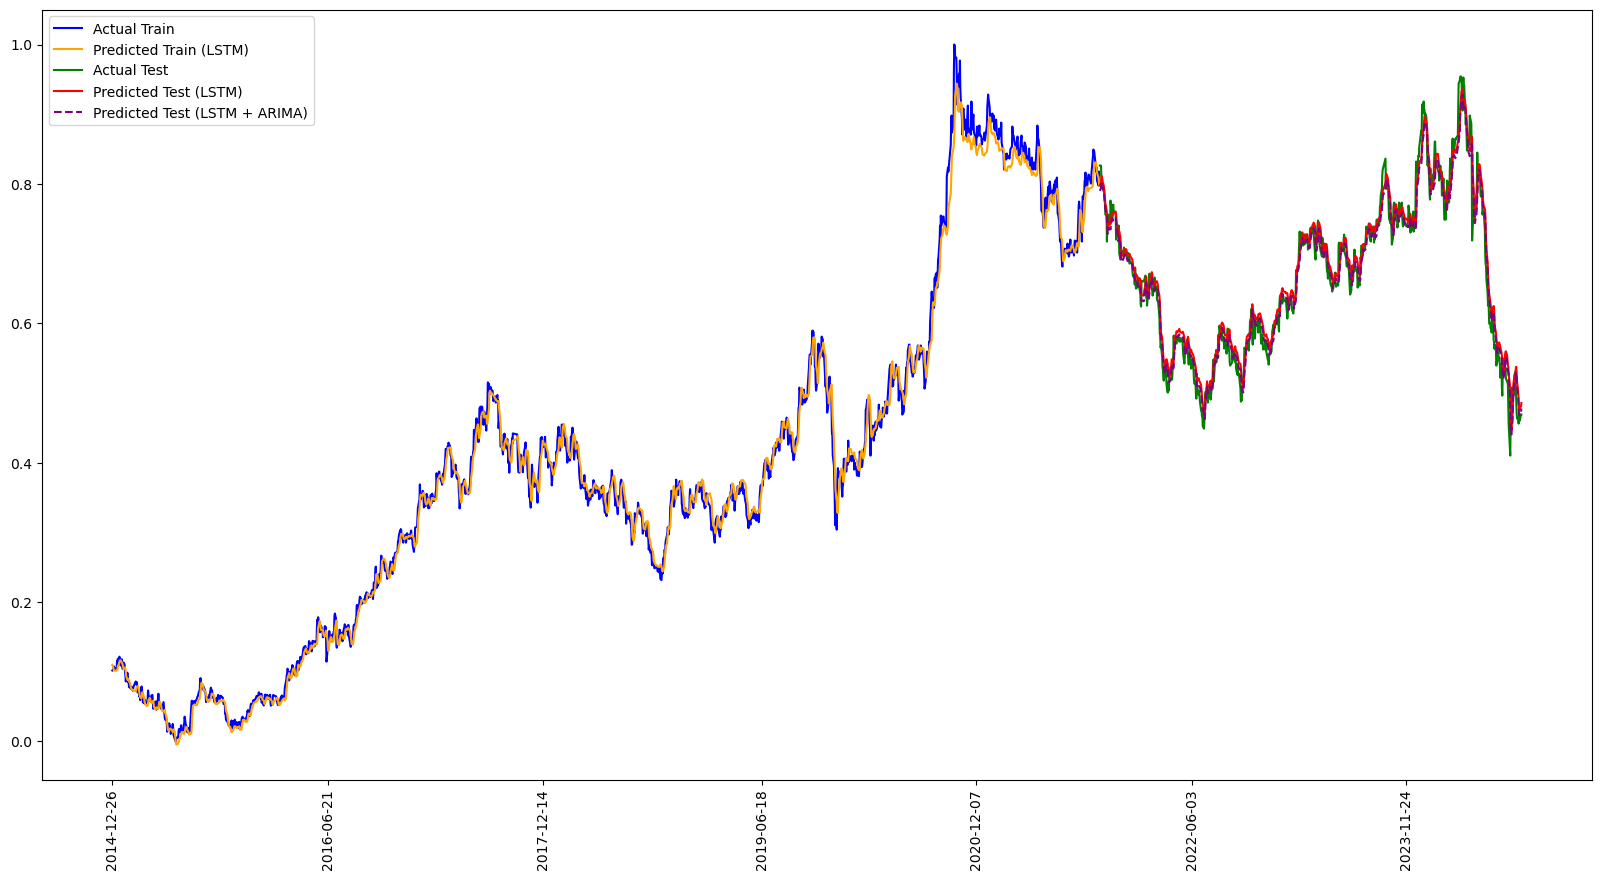

In [33]:
dates = dfMerged['Date'].values
sampleInterval = 365
sampledDates = dates[::sampleInterval]

plt.figure(figsize=(20, 10))

# Plot actual training values
plt.plot(dates[:len(trainY)], trainY, label='Actual Train', color='blue')

# Plot predicted training values (LSTM only)
plt.plot(dates[:len(trainPredict)], trainPredict, label='Predicted Train (LSTM)', color='orange')

# Plot actual test values
plt.plot(dates[len(trainY):len(trainY) + len(testY)], testY, label='Actual Test', color='green')

# Plot predicted test values (LSTM only)
plt.plot(dates[len(trainPredict):len(trainPredict) + len(testPredict)], testPredict, label='Predicted Test (LSTM)', color='red')

# Plot predicted test values (LSTM-ARIMA hybrid)
plt.plot(dates[len(trainPredict):len(trainPredict) + len(hybrid_predictions)], 
         hybrid_predictions, label='Predicted Test (LSTM + ARIMA)', color='purple', linestyle='--')

# Set xticks for the sampled dates
plt.xticks(sampledDates, rotation=90)

# Add legend
plt.legend()

# Show plot
plt.show()


In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Generate hybrid model predictions for training data
hybrid_train_predictions = model.predict(trainX)  # Ensure you replace 'model' with your actual hybrid model name

# Calculate metrics for LSTM-only model
mse_lstm = mean_squared_error(testY, testPredict)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(testY, testPredict)
r2_lstm = r2_score(testY, testPredict)

# Calculate metrics for LSTM-ARIMA hybrid model
mse_hybrid = mean_squared_error(testY, hybrid_predictions)
rmse_hybrid = np.sqrt(mse_hybrid)
mae_hybrid = mean_absolute_error(testY, hybrid_predictions)
r2_hybrid = r2_score(testY, hybrid_predictions)

# Print the results for LSTM-only model
print(f"LSTM-Only Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse_lstm:.5f}")
print(f"Root Mean Squared Error (RMSE): {rmse_lstm:.5f}")
print(f"Mean Absolute Error (MAE): {mae_lstm:.5f}")
print(f"R-squared (R²): {r2_lstm:.5f}")
print(f"Testing Accuracy: {100 - (rmse_lstm / np.mean(testY) * 100):.2f}%\n")

# Print the results for LSTM-ARIMA hybrid model
print(f"LSTM-ARIMA Hybrid Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse_hybrid:.5f}")
print(f"Root Mean Squared Error (RMSE): {rmse_hybrid:.5f}")
print(f"Mean Absolute Error (MAE): {mae_hybrid:.5f}")
print(f"R-squared (R²): {r2_hybrid:.5f}")
print(f"Testing Accuracy: {100 - (rmse_hybrid / np.mean(testY) * 100):.2f}%")


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
LSTM-Only Model Evaluation Metrics:
Mean Squared Error (MSE): 0.00054
Root Mean Squared Error (RMSE): 0.02328
Mean Absolute Error (MAE): 0.01813
R-squared (R²): 0.95814
Testing Accuracy: 96.51%

LSTM-ARIMA Hybrid Model Evaluation Metrics:
Mean Squared Error (MSE): 0.00048
Root Mean Squared Error (RMSE): 0.02188
Mean Absolute Error (MAE): 0.01638
R-squared (R²): 0.96303
Testing Accuracy: 96.72%


In [ ]:
import optuna
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import RMSprop

# Function to build the LSTM model
def create_model(neurons, dropout):
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, activation='tanh', input_shape=(lookBack, features.shape[1])))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, return_sequences=True, activation='tanh'))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, activation='tanh'))
    model.add(Dropout(dropout))
    model.add(Dense(units=1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=RMSprop())
    return model

# Objective function for optimization
def objective(trial):
    # Suggest hyperparameters
    neurons = trial.suggest_int('neurons', 50, 150)          # Range for neurons
    dropout = trial.suggest_uniform('dropout', 0.1, 0.5)     # Range for dropout
    batch_size = trial.suggest_int('batch_size', 8, 64)      # Range for batch size
    epochs = trial.suggest_int('epochs', 20, 100)            # Range for epochs

    # Create and train the model
    model = create_model(neurons, dropout)
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)
    
    # Return validation loss as the metric to minimize
    val_loss = min(history.history['val_loss'])
    return val_loss

# Create study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Best parameters found
best_params = study.best_params
print("Best parameters: ", best_params)


In [ ]:
# from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Function to evaluate model performance for different lookback values
def evaluate_lookback(stock_data, lookback_values, model):
    results = []
    features = stock_data.drop(['Date', 'Close'], axis=1).values
    target = stock_data['Close'].values

    scalerFeatures = MinMaxScaler(feature_range=(0, 1))
    scalerTarget = MinMaxScaler(feature_range=(0, 1))

    featuresScaled = scalerFeatures.fit_transform(features)
    targetScaled = scalerTarget.fit_transform(target.reshape(-1, 1))

    # Filter out-of-range lookback values
    max_lookback = len(featuresScaled)
    valid_lookbacks = [lb for lb in lookback_values if lb < max_lookback]

    for lookback in valid_lookbacks:
        # Prepare dataset
        X, y = createDataset(featuresScaled, targetScaled, lookback)
        
        # Train-test split
        train_size = int(len(X) * 0.7)
        trainX, testX = X[:train_size], X[train_size:]
        trainY, testY = y[:train_size], y[train_size:]

        # Reshape for LSTM
        trainX = np.reshape(trainX, (trainX.shape[0], lookback, trainX.shape[2]))
        testX = np.reshape(testX, (testX.shape[0], lookback, testX.shape[2]))
        
        # Train the model
        model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)

        # Evaluate the model
        predictions = model.predict(testX)
        mse = mean_squared_error(testY, predictions)
        results.append((lookback, mse))

    return results

# Automatically find and use the best lookback value
def find_best_lookback(stock_data, lookback_values, model):
    # Evaluate performance for all lookback values
    results = evaluate_lookback(stock_data, lookback_values, model)

    # Find the lookback with the lowest MSE
    if results:
        best_lookback, best_mse = min(results, key=lambda x: x[1])
        print(f"Best Lookback: {best_lookback}, MSE: {best_mse}")
        return best_lookback
    else:
        print("No valid lookback values found.")
        return None

# Example usage
lookback_values = [5, 10, 20, 30, 60, 90, 120, 150, 180]

# Assuming `model` is defined (e.g., an LSTM or another model)
best_lookback = find_best_lookback(stock_data, lookback_values, model)

if best_lookback is not None:
    # Use the best lookback for further processing
    print(f"Using Lookback: {best_lookback} for final training.")
